In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from model import VIN_torch, StateTrans

In [2]:
# Set parameters
def get_args():
    return {
        'input_dim': 1,
        'hidden_dim': 200,
        'sample_size': 50,
        'seed': 0,
        'num_steps': 45,
        'use_cuda': False
    }

class ObjectView(object):
    def __init__(self, dic): self.__dict__ = dic

In [35]:
args = ObjectView(get_args())
def get_model(args):
    trans = StateTrans(args.input_dim, args.hidden_dim)
    model = VIN_torch(trans, args.sample_size // 2, args.num_steps, args.use_cuda)
    
    model_path = 'vin-{}.pth'.format(args.seed)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    return model

data = get_dataset(seed = args.seed, samples = args.sample_size)
data = data['test_x'][:,:,0]
model = get_model(args)


In [38]:
def model_evaluate(model, data):
    T_max = data.shape[1]
    q = torch.autograd.Variable(data[:,1].unsqueeze(-1), requires_grad=True)
    dq = (data[:,1].unsqueeze(-1) - data[:,0].unsqueeze(-1)) / model.h
    
    q_list = [data[:,0].unsqueeze(-1), q]
    dq_list = [dq]
    for t in range(2, T_max):
        q, dq = model.trans(q, dq, model.h)
        q_list.append(q); dq_list.append(dq)
    
    return torch.cat(q_list, dim=-1), torch.cat(dq_list, dim=-1)

data_q = torch.tensor(data, dtype=torch.float32).to('cpu')
model.q1 = torch.nn.Parameter( data_q[:,0].unsqueeze(-1) )
model.q2 = torch.nn.Parameter( data_q[:,1].unsqueeze(-1) )

q = model(data_q)[0].detach()
q_dist = torch.distributions.Normal(loc=q, scale=.1)

print(q_pred)

print(q_dist.log_prob(data_q).sum())

tensor([[ -0.5816,  -0.3171,  -0.0520,  ...,   7.8273,   8.0169,   8.2065],
        [ -1.0183,  -1.3343,  -1.6155,  ..., -12.4489, -12.7183, -12.9877],
        [ -2.2366,  -2.2159,  -2.1962,  ...,  -2.2772,  -2.3008,  -2.3255],
        ...,
        [  1.5043,   1.7041,   1.9044,  ...,  10.0490,  10.2535,  10.4579],
        [ -0.9205,  -1.0157,  -1.0951,  ...,  -0.2765,  -0.3865,  -0.4963],
        [  0.7786,   0.6107,   0.4374,  ...,   0.9620,   0.8069,   0.6402]])
tensor(-2231568.7500)


In [32]:
R = 2
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)

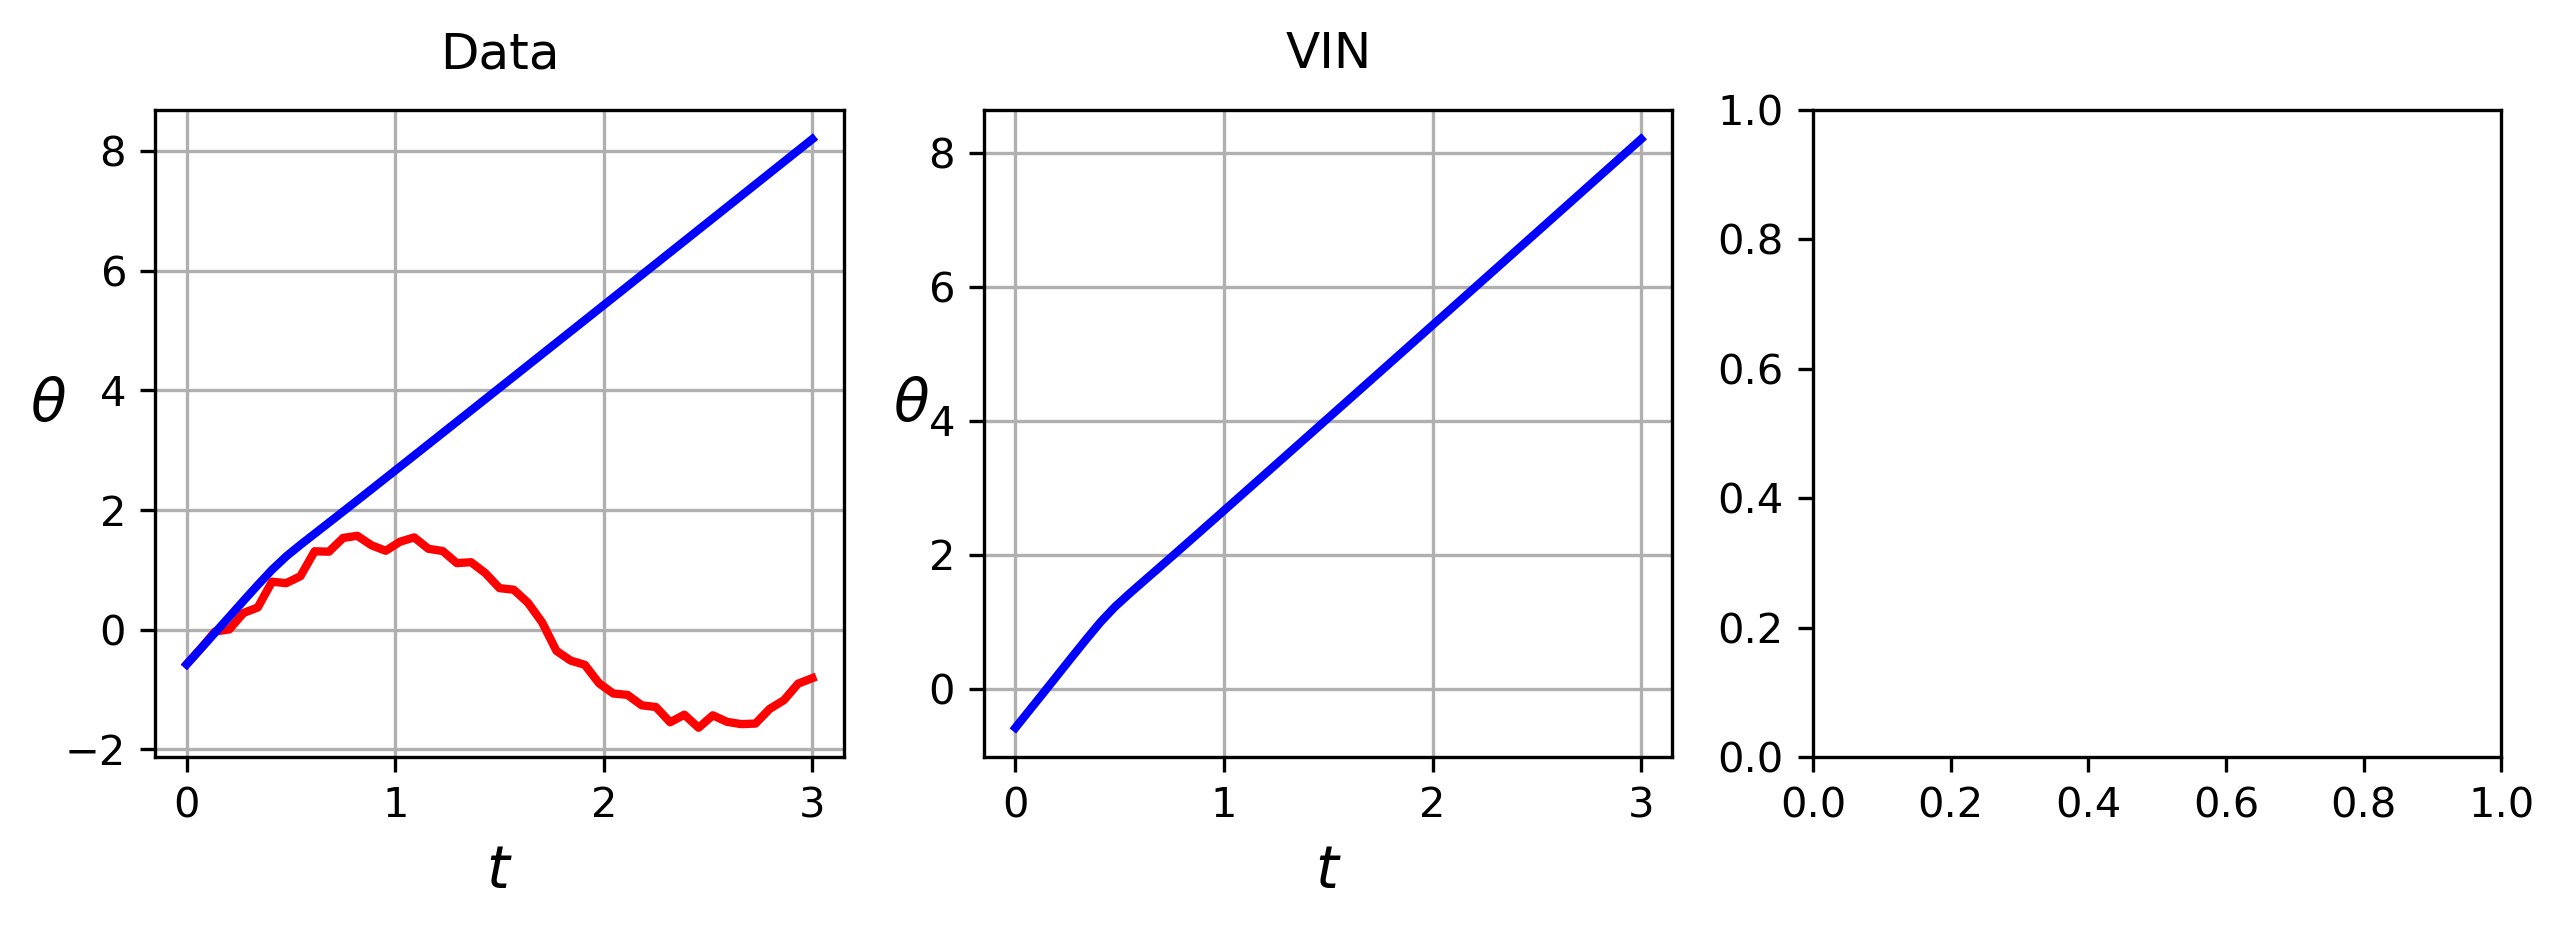

In [39]:
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=300)

fig.add_subplot(1, 4, 1, frameon=True)
t = np.linspace(0, 3, 45)
N = len(data)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.plot(t, data[0], label='data', linewidth=2, color='r')
plt.plot(t, q_pred[0], label='vin', linewidth=2, color='b')

plt.grid('.')
plt.xlabel('$t$', fontsize=14)
plt.ylabel(r'$\theta$', fontsize=14, rotation=0)
plt.title('Data', pad=10)

fig.add_subplot(1, 4, 2, frameon=True)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.plot(t, q[0], label='vin', linewidth=2, color='b')

plt.grid('.')
plt.xlabel('$t$', fontsize=14)
plt.ylabel(r'$\theta$', fontsize=14, rotation=0)
plt.title('VIN', pad=10)

fig.add_subplot(1, 4, 3, frameon=True)
plt.tight_layout(); plt.show()